##Import modules

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import strip_accents_ascii
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

filename = 'Cultivos.csv'
pd.set_option('display.max_columns', None)
data = pd.read_csv(filename, sep = ',')

##Info Description

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24788 entries, 0 to 24787
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TIPO                 24788 non-null  object
 1   MUNICIPIO            24788 non-null  object
 2   CULTIVO              24788 non-null  object
 3   PERIODO              24788 non-null  object
 4   Area Sembrada (ha)   24788 non-null  object
 5   Area Cosechada (ha)  24582 non-null  object
 6   Produccion (t)       24569 non-null  object
 7   Rendimiento (t/ha)   24557 non-null  object
 8   ALTITUD              24788 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 1.7+ MB


In [ ]:
data.head()

,TIPO,MUNICIPIO,CULTIVO,PERIODO,Area Sembrada (ha),Area Cosechada (ha),Produccion (t),Rendimiento (t/ha),ALTITUD
0,CULTIVOS PERMANENTES,RAQUIRA,AGRAZ,2015,170,170,1360,8,2150
1,CULTIVOS TRANSITORIOS SEMESTRE A,BUSBANZA,AHUYAMA,2018A,"0,5","0,4",2,5,2472
2,CULTIVOS PERMANENTES,BUENAVISTA,AGUACATE,2015,40,25,25,1,2200
3,CULTIVOS PERMANENTES,COPER,AGUACATE,2015,4,2,24,12,950
4,CULTIVOS PERMANENTES,COPER,AGUACATE,2015,20,10,70,7,950


In [ ]:
data.isnull().sum()

,0
TIPO,0
MUNICIPIO,0
CULTIVO,0
PERIODO,0
Area Sembrada (ha),0
Area Cosechada (ha),206
Produccion (t),219
Rendimiento (t/ha),231
ALTITUD,0


# **Data Visualization**

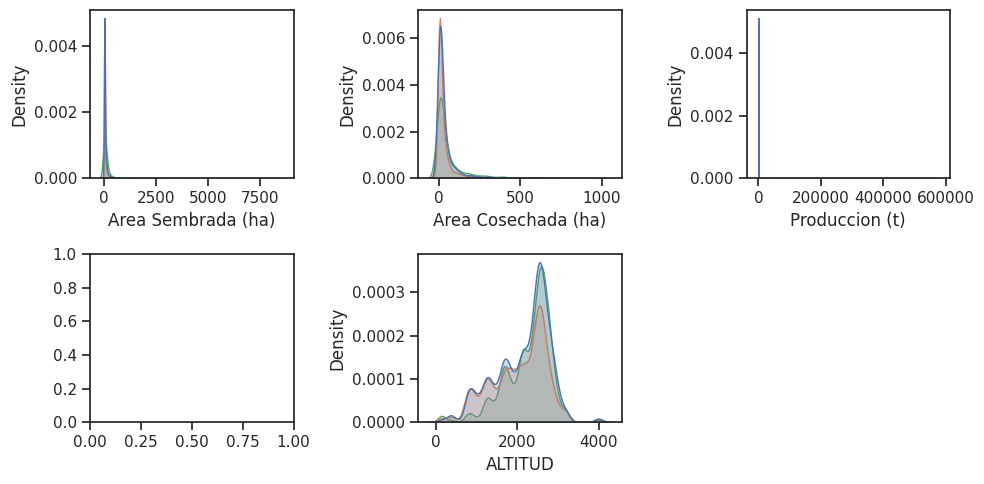

In [ ]:
# Pasar variables numericas de tipo object a float
to_view = data.copy()
params = ['Area Cosechada (ha)', 'Area Sembrada (ha)', 'Produccion (t)', 'Rendimiento (t/ha)']
for param in params:
  to_view[param] = to_view[param].str.replace(',', '.')
  to_view[param] = pd.to_numeric(to_view[param], errors='coerce')

to_view = to_view.select_dtypes(include=['int64', 'float64'])

correlation = to_view.corr()

to_view['Rendimiento (t/ha)'] = pd.to_numeric(data['Rendimiento (t/ha)'].str.replace(',', '.'), errors='coerce')
to_view['Rendimiento (t/ha)'] = pd.qcut(to_view['Rendimiento (t/ha)'], q=3, labels=['Bajo', 'Medio', 'Alto'])


rows = 2
cols = (to_view.shape[1] + rows - 1) // rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
axes = axes.flatten()

for i, col in enumerate(to_view.columns):
  if to_view[col].dtype in ['int64', 'float64']:
    sns.kdeplot(data=to_view, x=col, hue='Rendimiento (t/ha)', ax=axes[i], fill=True, color='skyblue', warn_singular=False, legend=False)

for i in range(len(to_view.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()

plt.savefig('Densityplots.png')

plt.show()

<ipython-input-281-c3da4034300c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=to_view, x=to_view['Rendimiento (t/ha)'], palette=colors)
<ipython-input-281-c3da4034300c>:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(data=to_view, x=to_view['Rendimiento (t/ha)'], palette=colors)


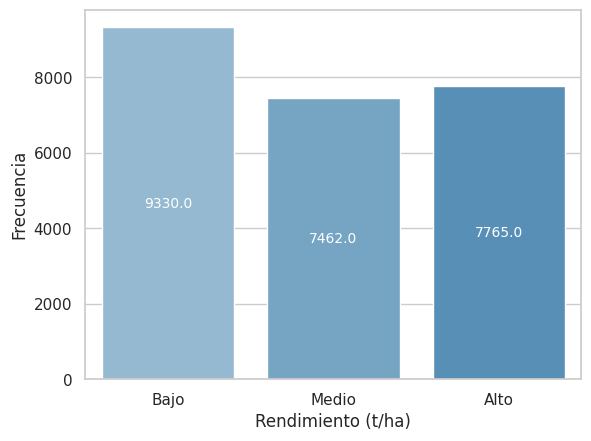

In [ ]:
sns.set(style="whitegrid")
colors = sns.color_palette("Blues_d")
sns.countplot(data=to_view, x=to_view['Rendimiento (t/ha)'], palette=colors)
# Agregar los conteos sobre las barras
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height/2,
             f'{p.get_height()}',
             ha='center', va='center',
             fontsize=10, color='white')
plt.ylabel('Frecuencia')
plt.savefig('Countplots.png',dpi=300)
plt.show()

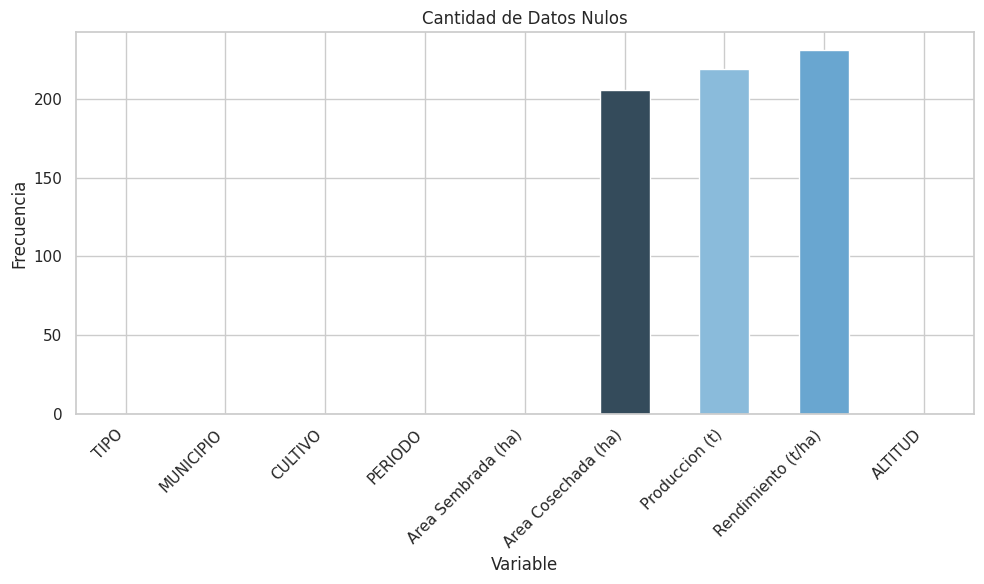

In [ ]:
null_counts = data.isnull().sum()

# Gráfico de barras para los valores nulos
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color=colors)
plt.title('Cantidad de Datos Nulos')
plt.xlabel('Variable')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Countplot_nulls.png')
plt.show()

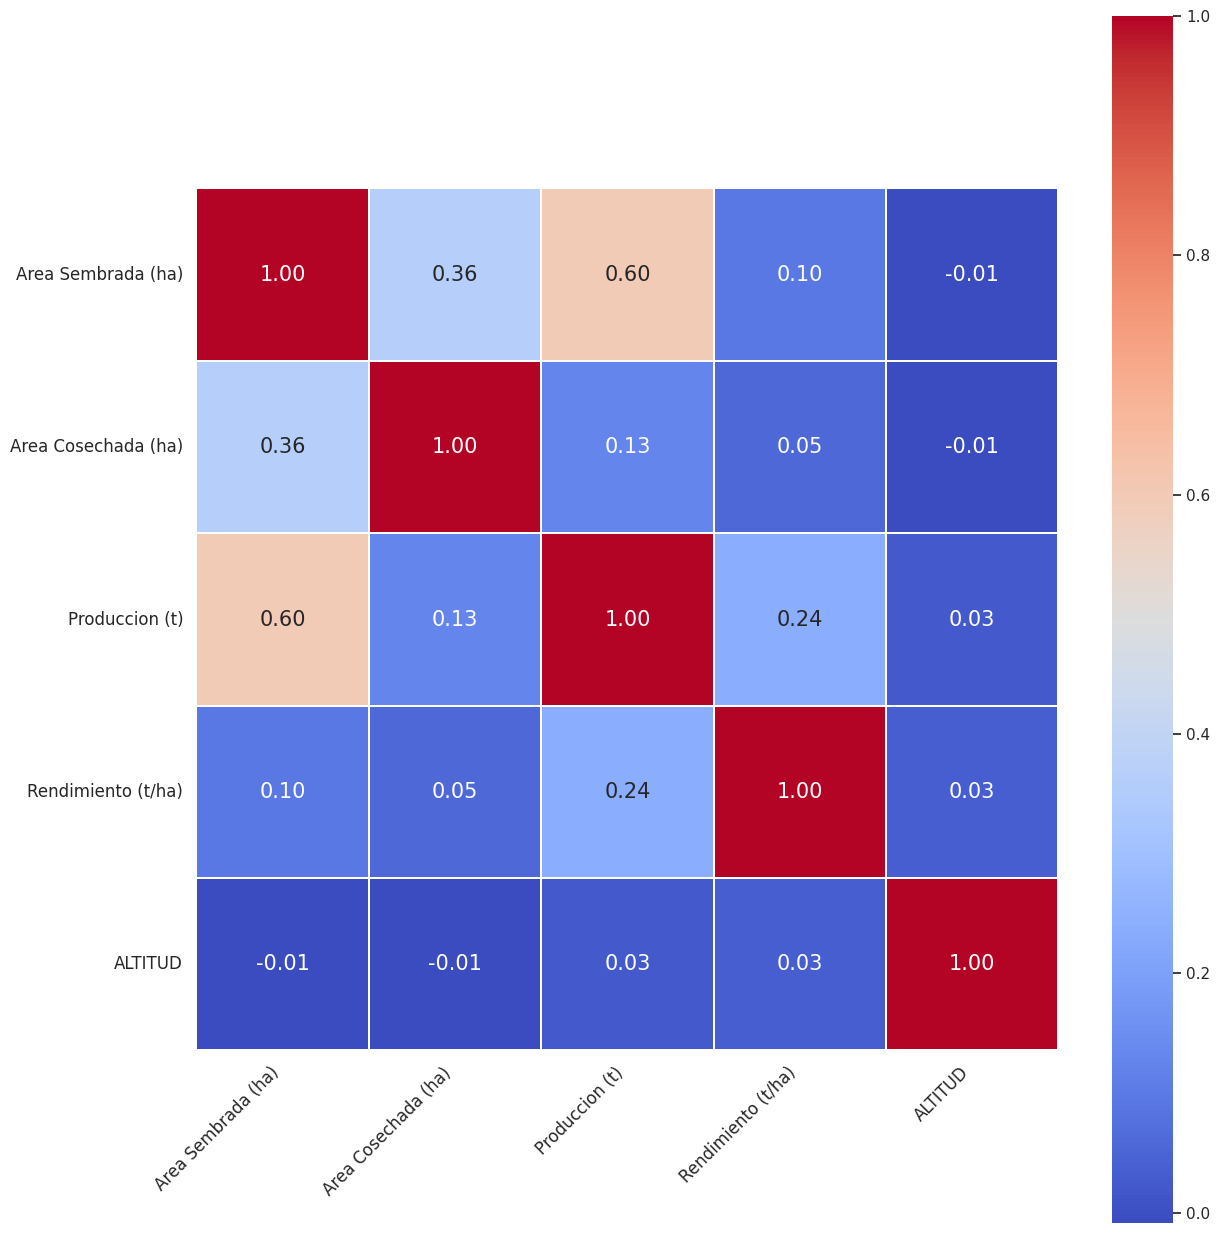

In [ ]:
# Gráficar el mapa de correlación entre las variables
plt.figure(figsize=(13, 13))
sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths=0.2, fmt='.2f', annot_kws={"size": 15}, square=True)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig('CorrelationMap.png',dpi=300)
plt.show()

#**Preprocessing**

In [ ]:
tmp = data.copy()

tmp.drop('PERIODO', axis=1, inplace=True)

# Pasar variables numericas de tipo object a float
params = ['Area Cosechada (ha)', 'Area Sembrada (ha)', 'Produccion (t)', 'Rendimiento (t/ha)']
for param in params:
  tmp[param] = tmp[param].str.replace(',', '.')
  tmp[param] = pd.to_numeric(tmp[param], errors='coerce')

# Pasar cultivos y textos a mayusculas y eliminar caracteres especiales
text_params = ['CULTIVO', 'MUNICIPIO']
for param in text_params:
  tmp[param] = tmp[param].str.upper()
  tmp[param] = tmp[param].apply(strip_accents_ascii)

#Unificar categorias de cultivos permanentes y transitorios
tipos = {'Permanente': 'CULTIVOS PERMANENTES', 'Transitorio': 'CULTIVOS TRANSITORIOS'}
tmp['TIPO'] = tmp['TIPO'].map(tipos).fillna(tmp['TIPO'])

# Categorizar las variables de tipo texto
label_encoder = LabelEncoder()
noncoded_params = ['TIPO', 'CULTIVO', 'MUNICIPIO']
for param in noncoded_params:
  tmp[param] = label_encoder.fit_transform(tmp[param])

tmp.head()

,TIPO,MUNICIPIO,CULTIVO,Area Sembrada (ha),Area Cosechada (ha),Produccion (t),Rendimiento (t/ha),ALTITUD
0,1,75,2,170.0,170.0,1360.0,8.0,2150
1,3,10,7,0.5,0.4,2.0,5.0,2472
2,1,9,4,40.0,25.0,25.0,1.0,2200
3,1,24,4,4.0,2.0,24.0,12.0,950
4,1,24,4,20.0,10.0,70.0,7.0,950


In [ ]:
# Rellenar valores nulos con la media
mean_params = ['Area Cosechada (ha)', 'Area Sembrada (ha)', 'Produccion (t)', 'Rendimiento (t/ha)']
for param in mean_params:
  tmp[param] = tmp[param].fillna(tmp[param].mean())

In [ ]:
print(tmp.shape)

whole_harvest = tmp[tmp['Area Cosechada (ha)'] == tmp['Area Sembrada (ha)']]
print('Cantidad de cultivos que tuvieron un 100% de cosecha: ',whole_harvest.shape[0])

mid_harvest = tmp[tmp['Area Cosechada (ha)'] / 2 == tmp['Area Sembrada (ha)']]
print('Cantidad de cultivos que tuvieron un 50% de cosecha: ',mid_harvest.shape[0])

less_harvest = tmp[tmp['Area Cosechada (ha)'] < tmp['Area Sembrada (ha)']]
print('Cantidad de cultivos que tuvieron menos cosecha que siembra: ',less_harvest.shape[0])

more_harvest = tmp[tmp['Area Cosechada (ha)'] > tmp['Area Sembrada (ha)']]
print('Cantidad de cultivos que tuvieron mas cosecha que siembra: ',more_harvest.shape[0])
print(whole_harvest.shape[0] + less_harvest.shape[0] + more_harvest.shape[0])

(24788, 8)
Cantidad de cultivos que tuvieron un 100% de cosecha:  12609
Cantidad de cultivos que tuvieron un 50% de cosecha:  94
Cantidad de cultivos que tuvieron menos cosecha que siembra:  11686
Cantidad de cultivos que tuvieron mas cosecha que siembra:  493
24788


In [ ]:
tmp['Rendimiento (t/ha)'] = pd.qcut(tmp['Rendimiento (t/ha)'], q=3, labels=['Bajo', 'Medio', 'Alto'])
tmp[]

features = tmp.drop(['Produccion (t)','Rendimiento (t/ha)'], axis=1)
target = tmp['Rendimiento (t/ha)']

ros = RandomOverSampler(random_state=1000)
x, y = ros.fit_resample(features, target)

#**Modelado**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

scaler =  StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [ ]:
# Instanciar Modelo
modelo = RandomForestClassifier(random_state=42)

# Hiperparametros
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    modelo,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


# **Entrenamiento y Validación**

In [ ]:
# Ajuste del modelo
random_search.fit(X_train, y_train)
print("Mejores parámetros:", random_search.best_params_)

# Validación cruzada con el modelo optimizado
scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
print(f"Accuracy promedio (validación cruzada): {scores.mean():.4f}")

Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Accuracy promedio (validación cruzada): 0.8611


In [ ]:
modelo = random_search.best_estimator_

In [ ]:
y_predict = modelo.predict(X_test)

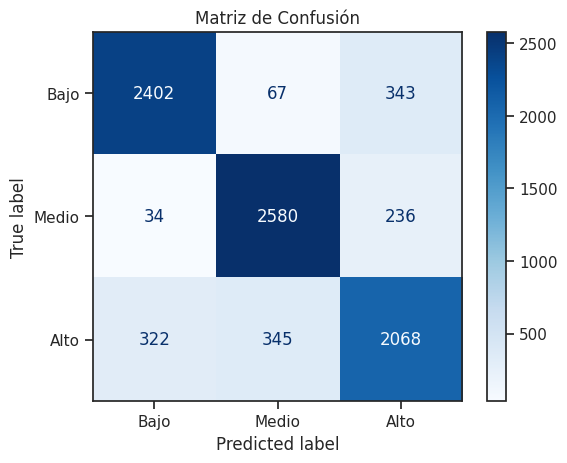

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style("ticks")
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_predict)

# Visualizar la matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bajo', 'Medio', 'Alto'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.savefig('ConfussionMatrix.png', dpi=300)
plt.show()

In [ ]:
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

        Alto       0.87      0.85      0.86      2812
        Bajo       0.86      0.91      0.88      2850
       Medio       0.78      0.76      0.77      2735

    accuracy                           0.84      8397
   macro avg       0.84      0.84      0.84      8397
weighted avg       0.84      0.84      0.84      8397

